In [319]:
import gym
import MCTSnet
import copy
import torch
from importlib import reload
from IPython import display
import time
import PIL
import copy
import marshal
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing environment

In [320]:
env = gym.make("SokobanEnc-v0")

In [321]:
len(env.solution)

293

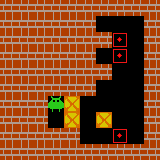

In [322]:
env.render()

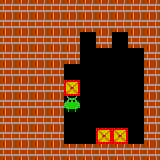

In [5]:
test = []
n_env = copy.deepcopy(env)
for k in reversed(n_env.solution):
    display.clear_output(wait=True)
    res = n_env.step(k)
    display.display(n_env.render())
    time.sleep(0.05)
    test.append(marshal.dumps(res[0]))

In [6]:
len(list(set(test)))

297

# Testing the four neural networks

In [323]:
e = MCTSnet.models.embedding.Epsilon()

In [324]:
state = torch.Tensor(res[0]).to(device)
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [325]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [326]:
reward = torch.tensor([res[1]], requires_grad=True).to(device)
action = torch.tensor([3.], requires_grad=True).to(device)

In [327]:
b = MCTSnet.models.backup.BetaMLP()

In [328]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [329]:
r = MCTSnet.models.readout.Rho()

In [330]:
r(h_s)

tensor([[0.1079, 0.1213, 0.1431, 0.1322, 0.1338, 0.1517, 0.1007, 0.1094]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [331]:
pi = MCTSnet.models.policy.Pi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [332]:
actions

tensor([[0.1212, 0.1229, 0.1451, 0.1205, 0.1213, 0.1234, 0.1204, 0.1252]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [333]:
torch.argmax(actions)

tensor(2, device='cuda:0')

In [334]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [335]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(b, e, pi, r)
m_net.env = env
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)).to(device))

In [336]:
prediction

tensor([[0.1254, 0.1231, 0.1303, 0.1297, 0.1192, 0.1345, 0.1298, 0.1081]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [337]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [338]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]).to(device))
loss.backward()

In [339]:
m_net.backup.fc1.weight.grad

tensor([[-1.0613e-05, -9.2756e-04, -1.0276e-06,  ..., -1.9513e-06,
          1.2318e-03, -1.2318e-02],
        [-3.3050e-07, -3.1819e-04,  1.6510e-06,  ..., -2.1129e-05,
          4.5626e-04, -6.7068e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00, -1.3925e-04,  0.0000e+00,  ..., -4.1685e-05,
          9.6690e-05,  0.0000e+00],
        [-1.4224e-05, -6.5381e-04,  0.0000e+00,  ..., -1.1816e-04,
          1.0423e-03, -2.0231e-02],
        [ 3.4522e-07,  2.6874e-04,  0.0000e+00,  ...,  0.0000e+00,
         -3.5349e-04,  3.5349e-03]], device='cuda:0')

In [340]:
m_net.embedding.input.weight.grad

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 7.4617e-06,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 7.4617e-06,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[ 1.0352e-04,  6.1803e-05,  6.4714e-05],
          [ 8.6165e-05,  7.0278e-05,  0.0000e+00],
          [ 1.0003e-04,  8.0902e-05,  1.0624e-05]],

         [[ 1.2782e-05,  7.6891e-06,  1.8942e-05],
          [-1.6284e-05,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[-1.6284e-05,  0.0000e+00,  0.0000e+00],
          [ 0.000

as "expected" the policy doesn't learn and may require additionnal work

In [341]:
m_net.policy.piL.fc1.weight.grad

In [342]:
m_net.readout.fc1.weight.grad

tensor([[-3.0171e-04, -1.0741e-02, -0.0000e+00,  ..., -0.0000e+00,
         -5.0444e-03, -5.6999e-03],
        [ 4.2334e-05,  1.5071e-03,  0.0000e+00,  ...,  0.0000e+00,
          7.0778e-04,  7.9976e-04],
        [ 4.5176e-05,  1.6083e-03,  0.0000e+00,  ...,  0.0000e+00,
          7.5531e-04,  8.5346e-04],
        ...,
        [ 4.6891e-05,  1.6693e-03,  0.0000e+00,  ...,  0.0000e+00,
          7.8398e-04,  8.8586e-04],
        [ 4.4984e-05,  1.6014e-03,  0.0000e+00,  ...,  0.0000e+00,
          7.5209e-04,  8.4982e-04],
        [ 3.6561e-05,  1.3016e-03,  0.0000e+00,  ...,  0.0000e+00,
          6.1127e-04,  6.9070e-04]], device='cuda:0')

In [343]:
m_net.state_dict

<bound method Module.state_dict of MCTSnet(
  (backup): BetaMLP(
    (fc1): Linear(in_features=258, out_features=128, bias=True)
  )
  (embedding): Epsilon(
    (input): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (out): Linear(in_features=3200, out_features=128, bias=True)
  )
  (policy): Pi(
    (piL): PiLogits(
      (fc1): Linear(in_features=128, out_features=8, bias=True)
    )
    (piPL): PiPriorLogits(
      (input): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(32,

# Trainer

In [28]:
reload(MCTSnet.trainer)
reload(MCTSnet)
sokoban = MCTSnet.MCTSnetSokoban((4, 10, 10), n_embeddings=128, n_actions=4, n_simulations=10)

In [29]:
# sokoban.train(500)

KeyboardInterrupt: 

# Attempt at Mouse game

Here we attempt to train the model to imitate a very basic MCTS. More precisely the net must guess the expectation of each action based on the explored graph.

In [483]:
reload(MCTSnet.trainer)
reload(MCTSnet.models.readout)
reload(MCTSnet.mouse.game)
reload(MCTSnet.mouse.solver)
env = MCTSnet.mouse.game.EnvironmentExploring()

bleu +10, jaune -10

In [484]:
state = env.reset()

In [485]:
state.shape

(3, 14, 14)

In [486]:
mnet = MCTSnet.trainer.MCTSnetMouse(n_simulations=15)

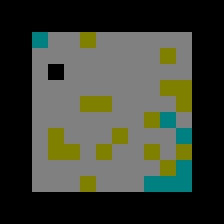

Score: -187.0


In [470]:
mnet.play_solution(4, max_steps=200)

In [ ]:
mnet.train(400, 1, 200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.96it/s]


[1,   199] mean loss: 11.166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.03it/s]


[1,   399] mean loss: 10.696


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.67it/s]


[1,   599] mean loss: 7.489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 22.18it/s]


[1,   799] mean loss: 8.185


 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                       | 64/200 [00:02<00:05, 23.80it/s]

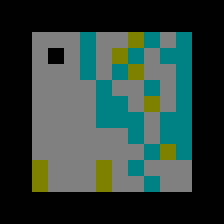

In [481]:
mnet.play(35)